--------------------------<br>
IMPORTS<br>
--------------------------

In [349]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.utils import FeatureSpace
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTENC
import imblearn

# Try augmentation with https://towardsdatascience.com/augmenting-categorical-datasets-with-synthetic-data-for-machine-learning-a25095d6d7c8
from sklearn.mixture import GaussianMixture as GMM
import numpy.linalg as lnalg
from scipy.spatial.distance import mahalanobis

In [350]:
keras.utils.set_random_seed(42)

In [351]:
print("Reading data...")

Reading data...


--------------------------<br>
LOAD DATASET<br>
--------------------------

--------------------------<br>
PREPROCESSING<br>
--------------------------

<Axes: xlabel='Target', ylabel='count'>

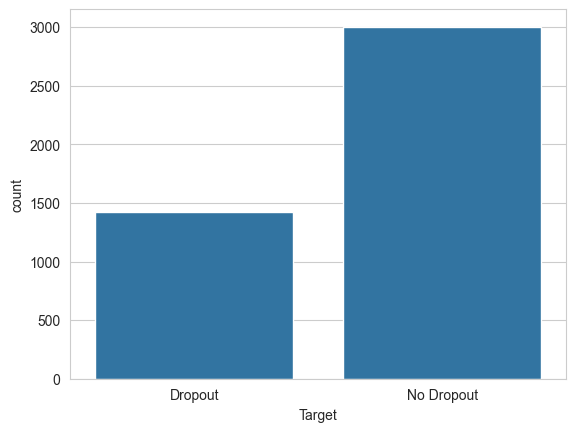

In [352]:
data = pd.read_csv('dropout.csv', delimiter=';')
# TODO: do this thoroughly. some keras libraries can only handle ^[A-Za-z0-9.][A-Za-z0-9_.\\/>-]*$
data.rename(columns={
    "Admission grade" : "Admission_grade",
    "Daytime/evening attendance\t" : "Daytime_evening_attendance",
    "Curricular units 2nd sem (approved)" : "Curricular_units_2nd_sem_approved",
}, inplace=True)
n_classes = 2

if n_classes == 2:
    data.loc[data["Target"] == "Graduate", "Target"] = "No Dropout"
    data.loc[data["Target"] == "Enrolled", "Target"] = "No Dropout"

sns.set_style("whitegrid")
sns.countplot(data, x="Target")

Split into validation and training dataset

In [353]:
#data = data.drop(["Educational special needs", "Nacionality", "International", "Unemployment rate", "Father's qualification", "Mother's occupation", "Father's occupation", "Inflation rate"], axis=1)

In [354]:
data_val = data.sample(frac=0.2, random_state=42)
data_train = data.drop(data_val.index)

In [355]:
# SMOTE oversampling
categorical = [
"Marital status",
"Application mode",
"Course",
"Daytime/evening attendance\t",
"Previous qualification",
"Nacionality",
"Mother's qualification",
"Father's qualification",
"Mother's occupation",
"Father's occupation",
"Displaced",
"Educational special needs",
"Debtor",
"Tuition fees up to date",
"Gender",
"Scholarship holder",
"International",
]
oversample = SMOTENC(categorical, sampling_strategy='minority')

#X, y = oversample.fit_resample(data_train.drop(columns="Target"), data_train["Target"])

#data_train = pd.concat([X,y], axis=1)
#sns.countplot(data_train["Target"])

In [356]:
# simple oversampling
#randomsampler = imblearn.over_sampling.RandomOverSampler(random_state=42, sampling_strategy='minority')
randomsampler = imblearn.under_sampling.RandomUnderSampler()

#X, y = randomsampler.fit_resample(data_train.drop(columns="Target"), data_train["Target"])
#data_train = pd.concat([X,y], axis=1)
#sns.countplot(data_train["Target"])

In [357]:
def dataframe_to_dataset(df):
    df = df.copy()
    labels_str = df.pop('Target')
    labels = pd.get_dummies(labels_str)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    return ds

In [358]:
def dataframe_to_dataset_balanced(df):
    df = df.copy()
    labels_str = df.pop('Target')
    labels = pd.get_dummies(labels_str)
    ds1 = tf.data.Dataset.from_tensor_slices((dict(df[labels_str == "Enrolled"]), labels[labels_str=="Enrolled"]))
    ds2 = tf.data.Dataset.from_tensor_slices((dict(df[labels_str == "Dropout"]), labels[labels_str=="Dropout"]))
    ds3 = tf.data.Dataset.from_tensor_slices((dict(df[labels_str == "Graduate"]), labels[labels_str=="Graduate"]))

    resampled = tf.data.Dataset.sample_from_datasets([ds1, ds2, ds3], weights=[0.33, 0.33, 0.33])
    return resampled

In [359]:
ds_val = dataframe_to_dataset(data_val)
ds_train = dataframe_to_dataset(data_train)
#ds_train = dataframe_to_dataset_balanced(data_train)

In [360]:
ds_val = ds_val.batch(64)
ds_train = ds_train.batch(64)

ideas for combinations (either by feature space or by hand)<br>
difference "curricular units credited - enrolled

try out binning for age<br>
application order: treat it as a continous value

In [361]:
print("Preprocessing data...")

Preprocessing data...


In [362]:
feature_space = FeatureSpace(
    features={
        "Marital status": FeatureSpace.integer_categorical(),
        "Application mode": FeatureSpace.integer_categorical(),
        "Application order": FeatureSpace.float_normalized(),
        "Application order": FeatureSpace.float_rescaled(),
        "Course": FeatureSpace.integer_categorical(),
        "Daytime_evening_attendance": FeatureSpace.integer_categorical(),
        "Previous qualification" : FeatureSpace.integer_categorical(),
        "Previous qualification (grade)" : FeatureSpace.float_normalized(),                                  # try float_rescaled
        "Nacionality" : FeatureSpace.integer_categorical(),
        "Mother's qualification" : FeatureSpace.integer_categorical(),
        "Father's qualification" : FeatureSpace.integer_categorical(),
        "Mother's occupation" : FeatureSpace.integer_categorical(),
        "Father's occupation" : FeatureSpace.integer_categorical(),
        "Admission_grade" : FeatureSpace.float_normalized(),                                                 # try float_rescaled
        "Displaced" : FeatureSpace.integer_categorical(),
        "Educational special needs" : FeatureSpace.integer_categorical(),
        "Debtor" : FeatureSpace.integer_categorical(),
        "Tuition fees up to date" : FeatureSpace.integer_categorical(),
        "Gender" : FeatureSpace.integer_categorical(),
        "Scholarship holder" : FeatureSpace.integer_categorical(),
        "Age at enrollment" : FeatureSpace.float_normalized(),                                               # maybe float_discretized
        "International": FeatureSpace.integer_categorical(),
        "Curricular units 1st sem (credited)" : FeatureSpace.float_normalized(),
        "Curricular units 1st sem (enrolled)" : FeatureSpace.float_normalized(),
        "Curricular units 1st sem (evaluations)" : FeatureSpace.float_normalized(),
        "Curricular units 1st sem (approved)" : FeatureSpace.float_normalized(),
        "Curricular units 1st sem (grade)" : FeatureSpace.float_normalized(),
        "Curricular units 1st sem (without evaluations)" : FeatureSpace.float_normalized(),
        "Curricular units 2nd sem (credited)" : FeatureSpace.float_normalized(),
        "Curricular units 2nd sem (enrolled)" : FeatureSpace.float_normalized(),
        "Curricular units 2nd sem (evaluations)" : FeatureSpace.float_normalized(),
        "Curricular_units_2nd_sem_approved" : FeatureSpace.float_normalized(),
        "Curricular units 2nd sem (grade)" : FeatureSpace.float_normalized(),
        "Curricular units 2nd sem (without evaluations)" : FeatureSpace.float_normalized(),
        "Unemployment rate" : FeatureSpace.float_normalized(),
        "Inflation rate" : FeatureSpace.float_normalized(),
        "GDP" : FeatureSpace.float_normalized(),
    },
    #crosses=[("Curricular_units_2nd_sem_approved", "Admission_grade")],
    #crossing_dim=32,
    #crosses = [FeatureSpace.cross(feature_names=("Curricular_units_2nd_sem_approved", "Admission_grade"), crossing_dim=32)],
    output_mode="concat"
)

In [363]:
ds_train_no_labels = ds_train.map(lambda x, _:x)
feature_space.adapt(ds_train_no_labels)

2023-11-09 12:37:24.471887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2023-11-09 12:37:24.552938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2023-11-09 12:37:24.624589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2023-11-09 12:37:24.706681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2023-11-09 12:37:24.776992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2023-11-09 12:37:24.856316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2023-11-09 12:37:24.925411: W tensorflow/core/framework/local_rendezvous.cc:404] L

2023-11-09 12:37:28.609917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2023-11-09 12:37:28.670139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2023-11-09 12:37:28.759952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2023-11-09 12:37:28.829820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2023-11-09 12:37:28.919586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2023-11-09 12:37:28.982634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2023-11-09 12:37:29.082565: W tensorflow/core/framework/local_rendezvous.cc:404] L

In [364]:
ds_train_preprocessed = ds_train.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
ds_train_preprocessed = ds_train_preprocessed.prefetch(tf.data.AUTOTUNE)

In [365]:
ds_val_preprocessed = ds_val.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
ds_val_preprocessed = ds_val_preprocessed.prefetch(tf.data.AUTOTUNE)

In [366]:
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()

In [367]:
, kernel_initializer = keras.initializers.GlorotNormal()
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.L2(1e-5), bias_regularizer=keras.regularizers.L2(1e-5), kernel_initializer = keras.initializers.GlorotNormal())(encoded_features)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.L2(1e-5), bias_regularizer=keras.regularizers.L2(1e-5), kernel_initializer = keras.initializers.GlorotNormal())(x)
x = keras.layers.Dropout(0.6)(x)
predictions = keras.layers.Dense(n_classes, activation="softmax")(x)

In [368]:
# class weights are only valuable if we want to move precision/recall
# it basically assigns more samples to the underrepresented class
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(np.concatenate([y for _,y in ds_train], axis=0), axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)

d_class_weights = dict(enumerate(class_weights))
d_class_weights = {
    0 : 0.5,
    1 : 10.0,
    2 : 10.0
}
d_class_weights

2023-11-09 12:37:30.059359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{0: 0.5, 1: 10.0, 2: 10.0}

In [369]:
model = keras.Model(inputs=encoded_features, outputs=predictions)
model.compile(
    optimizer="adam", loss="binary_crossentropy", 
        metrics=[
            "accuracy",
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            #keras.metrics.F1Score(name='f1'),
        ]
)
keras.utils.plot_model(model, to_file="dl-model.png", show_shapes=True, rankdir="LR", show_layer_activations=True)

# use interference model with raw data / built in preprocessing
inference_model = keras.Model(inputs=dict_inputs, outputs=predictions)

In [370]:
history = model.fit(
    ds_train_preprocessed, 
    epochs=40, 
    validation_data=ds_val_preprocessed, 
    verbose=1,
    class_weight=d_class_weights
)

Epoch 1/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6396 - loss: 2.9393 - precision: 0.6396 - recall: 0.6396 - val_accuracy: 0.6429 - val_loss: 1.4015 - val_precision: 0.6429 - val_recall: 0.6429
Epoch 2/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6902 - loss: 0.8153 - precision: 0.6902 - recall: 0.6902 - val_accuracy: 0.6475 - val_loss: 1.1466 - val_precision: 0.6475 - val_recall: 0.6475
Epoch 3/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6988 - loss: 0.6825 - precision: 0.6988 - recall: 0.6988 - val_accuracy: 0.6780 - val_loss: 1.0345 - val_precision: 0.6780 - val_recall: 0.6780
Epoch 4/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7176 - loss: 0.6311 - precision: 0.7176 - recall: 0.7176 - val_accuracy: 0.6927 - val_loss: 1.0239 - val_precision: 0.6927 - val_recall: 0.6927
Epoch 5/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7470 - loss: 0.5806 - precision: 0.7470 - recall: 0.7470 - val_accuracy: 0.7232 - val_loss: 0.8709 - val

Epoch 35/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8681 - loss: 0.3255 - precision: 0.8681 - recall: 0.8681 - val_accuracy: 0.8169 - val_loss: 0.7183 - val_precision: 0.8169 - val_recall: 0.8169
Epoch 36/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8796 - loss: 0.2901 - precision: 0.8796 - recall: 0.8796 - val_accuracy: 0.8169 - val_loss: 0.7163 - val_precision: 0.8169 - val_recall: 0.8169
Epoch 37/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8814 - loss: 0.2849 - precision: 0.8814 - recall: 0.8814 - val_accuracy: 0.8113 - val_loss: 0.7601 - val_precision: 0.8113 - val_recall: 0.8113
Epoch 38/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8698 - loss: 0.2977 - precision: 0.8698 - recall: 0.8698 - val_accuracy: 0.8136 - val_loss: 0.7341 - val_precision: 0.8136 - val_recall: 0.8136
Epoch 39/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8909 - loss: 0.2804 - precision: 0.8909 - recall: 0.8909 - val_accuracy: 0.8192 - val_loss: 0.7578 

In [371]:
def plot_metrics(history):
    plt.plot(history.epoch, history.history['val_accuracy'], label="Accuracy")
    plt.plot(history.epoch, history.history['val_precision'], label="Precision")
    plt.plot(history.epoch, history.history['val_recall'], label="Recall")
    
    plt.plot(history.epoch, history.history['accuracy'], label="Accuracy (train)")
    plt.plot(history.epoch, history.history['precision'], label="Precision (train)")
    plt.plot(history.epoch, history.history['recall'], label="Recall (train)")
    #plt.plot(history.epoch, history.history['val_f1'], label="F1")
    plt.ylim([0.5,1])
    plt.legend()
    plt.show()

In [380]:
def plot_confusion(ds_val):
    raw_predictions = np.array([]).reshape(0, n_classes)
    trues = np.array([])
    for x,y in ds_val:
        raw_predictions = np.concatenate([raw_predictions, inference_model.predict(x, verbose = 0)])
        trues = np.concatenate([trues, np.argmax(y.numpy(), axis=1)])
        
    # does not work if ds.shuffle() is on - ds.shuffle() improves training
    #raw_predictions = inference_model.predict(ds_val)
    #trues = np.argmax(np.concatenate([y for _,y in ds_val], axis=0), axis=1)

    predictions = np.argmax(raw_predictions, axis=1)
    
    confusion = confusion_matrix(predictions, trues)
    if n_classes == 2:
        s = sns.heatmap(confusion, annot=True , fmt="3d", cmap="Blues", xticklabels=["Dropout", "No Dropout"], yticklabels=["Dropout", "No Dropout"])
    else:
        s = sns.heatmap(confusion, annot=True , fmt="3d", cmap="Blues", xticklabels=["Dropout", "Graduate", "Enrolled"], yticklabels=["Dropout", "Graduate", "Enrolled"])

    s.set(xlabel="predicted class", ylabel="true class")
    s.set_title("Confusion Matrix (Neural Network)")
    plt.show()
    print("F1:", f1_score(trues, predictions, average='macro'))
    return raw_predictions, trues

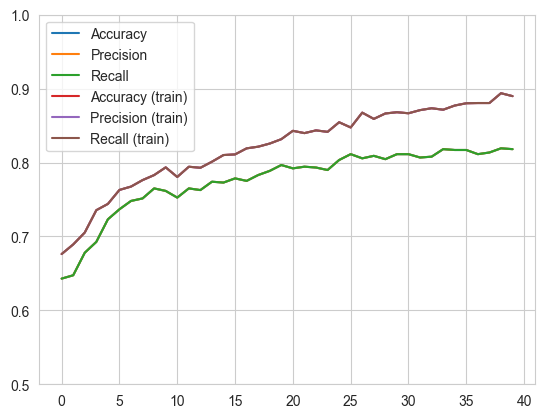

2023-11-09 12:41:12.068043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


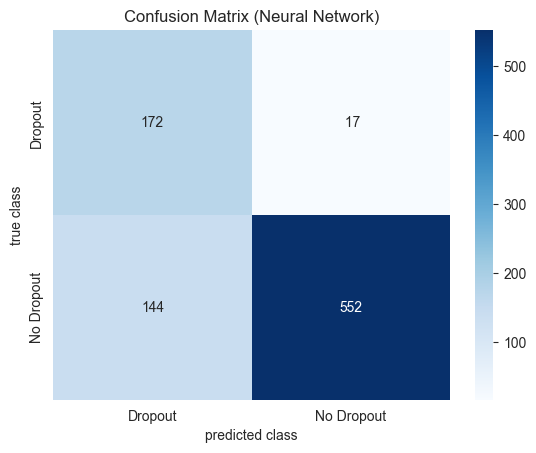

F1: 0.776957695769577


In [381]:
plot_metrics(history)
raw_predictions, trues = plot_confusion(ds_val)

In [374]:
false_predictions = raw_predictions[np.argmax(raw_predictions, axis=1) != trues]
false_trues = trues[np.argmax(raw_predictions, axis=1) != trues]
print("Std deviation:", np.std(np.max(false_predictions, axis=1)))
print("Mean:\t\t", np.mean(np.max(false_predictions, axis=1)))

Std deviation: 0.10441069732054309
Mean:		 0.9538044089115925


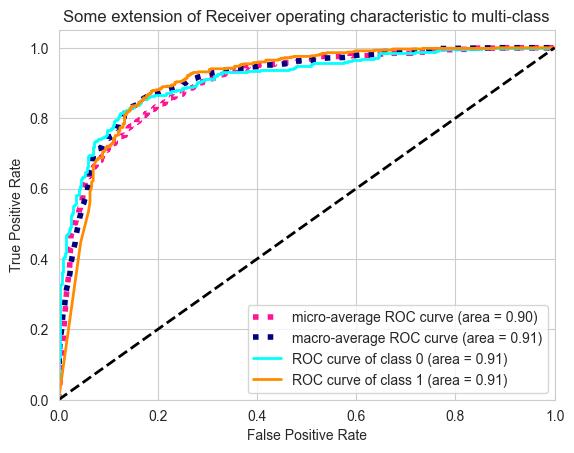

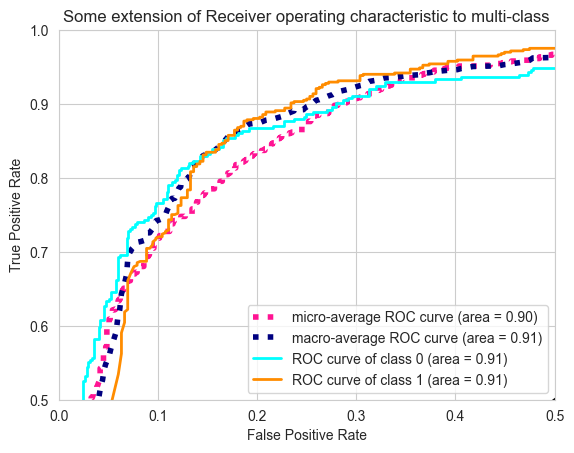

In [375]:
from sklearn.metrics import auc, roc_curve    
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer

from numpy import interp
from itertools import cycle

# plot roc curve
# ROC and AUC for each class                                                                         
fpr = dict()                                                                                         
tpr = dict()                                                                                         
roc_auc = dict() 
if n_classes == 3:
    trues_bin = label_binarize(trues, classes=np.unique(trues))
else:
    lb = LabelBinarizer()
    labels = lb.fit_transform(trues)
    trues_bin = np.hstack((1- labels, labels))
    
for i in range(n_classes):                                                                           
    fpr[i], tpr[i], _ = roc_curve(trues_bin[:, i], raw_predictions[:, i])                                
    roc_auc[i] = auc(fpr[i], tpr[i])                                                                 
                                                                                                     
# micro average roc curve                                                                            
fpr['micro'], tpr['micro'], _ = roc_curve(trues_bin.ravel(), raw_predictions.ravel())                    
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])                                                   
                                                                                                     
# macro average roc curve                                                                            
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))                              
mean_tpr = np.zeros_like(all_fpr)                                                                    
for i in range(n_classes):                                                                           
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])                                                      
mean_tpr /= n_classes                                                                                
                                                                                                     
fpr['macro'] = all_fpr                                                                               
tpr['macro'] = mean_tpr                                                                              
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])   

lw = 2                                                                                               
                                                                                                     
plt.figure(1)                                                                                        
plt.plot(fpr["micro"], tpr["micro"],                                                                 
         label='micro-average ROC curve (area = {0:0.2f})'                                           
               ''.format(roc_auc["micro"]),                                                          
         color='deeppink', linestyle=':', linewidth=4)                                               
                                                                                                     
plt.plot(fpr["macro"], tpr["macro"],                                                                 
         label='macro-average ROC curve (area = {0:0.2f})'                                           
               ''.format(roc_auc["macro"]),                                                          
         color='navy', linestyle=':', linewidth=4)                                                   
                                                                                                     
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])                                             
for i, color in zip(range(n_classes), colors):                                                       
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,                                                     
             label='ROC curve of class {0} (area = {1:0.2f})'                                        
             ''.format(i, roc_auc[i]))                                                               
                                                                                                     
plt.plot([0, 1], [0, 1], 'k--', lw=lw)                                                               
plt.xlim([0.0, 1.0])                                                                                 
plt.ylim([0.0, 1.05])                                                                                
plt.xlabel('False Positive Rate')                                                                    
plt.ylabel('True Positive Rate')                                                                     
plt.title('Some extension of Receiver operating characteristic to multi-class')                      
plt.legend(loc="lower right")                                                                        
plt.show() 

# Zoom in view of the upper left corner.                                                             
plt.figure(2)                                                                                        
plt.xlim(0, 0.5)                                                                                     
plt.ylim(0.5, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4) 

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
